<a href="https://colab.research.google.com/github/sajidcsecu/polarImage/blob/main/PolarImage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Polar Image conversion

In [5]:
 #linear polar
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import geometric_transform


class PolarImageTransformation:
  def car_to_pol_chun(self,image,scaling_factor=4):
    height, width = image.shape
    center_x, center_y = width // 2, height // 2

    # Define output polar image size
    polar_height = int(scaling_factor * height)  # Radial resolution
    polar_width = int(scaling_factor * width)    # Angular resolution
    polar_image = np.zeros((polar_height, polar_width), dtype=image.dtype)

    # Create grids for radius (r) and angle (theta)
    r = np.linspace(0, 1, polar_height)  # Normalized radius (0 to 1)
    theta = np.linspace(0, 2 * np.pi, polar_width)  # Full 360-degree range

    # Create meshgrid in polar coordinates
    t, r = np.meshgrid(theta, r, indexing='xy')

    # Convert polar coordinates to Cartesian coordinates
    x = (r * (width / 2) * np.cos(t)).astype(int) + center_x
    y = -(r * (height / 2) * np.sin(t)).astype(int) + center_y + 1

    # Clip coordinates to prevent out-of-bounds errors
    x = np.clip(x, 0, width - 1)
    y = np.clip(y, 0, height - 1)

    # Map pixel values from Cartesian to Polar coordinates
    polar_image[:, :] = image[y, x]

    return polar_image

  def pol_to_car_chun(self, polar_image,  scaling_factor=4):
    height, width = polar_image.shape
    cart_height, cart_width = int(height/scaling_factor), int(width/scaling_factor)
    center_x, center_y = cart_width // 2, cart_height // 2

    # Create Cartesian coordinate grids
    y, x = np.meshgrid(np.arange(cart_height), np.arange(cart_width), indexing='ij')

    # Convert Cartesian coordinates to polar coordinates
    r = np.sqrt((x - center_x) ** 2 + (center_y+1-y) ** 2)
    theta = np.arctan2(center_y+1-y, x - center_x)

    # Normalize radius and scale theta
    r = r / (cart_width / 2)  # Normalize radius to range [0,1]
    r = np.clip(r, 0, 1)  # Ensure radius stays within bounds
    theta[theta < 0] += 2 * np.pi  # Convert negative angles to positive
    theta = theta / (2 * np.pi)  # Normalize theta to range [0,1]

    # Convert normalized r, theta to polar image indices
    r_idx = (r * (polar_image.shape[0] - 1)).astype(int)
    theta_idx = (theta * (polar_image.shape[1] - 1)).astype(int)

    # Ensure indices are within valid range
    r_idx = np.clip(r_idx, 0, polar_image.shape[0] - 1)
    theta_idx = np.clip(theta_idx, 0, polar_image.shape[1] - 1)

    # Map pixels from polar to Cartesian
    cartesian_image = polar_image[r_idx, theta_idx]

    return cartesian_image

  def display_image(self,title,oimage,pimage,rimage):
    # Visualize the original and polar images
    plt.figure(title,figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(oimage, cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.title("Polar Coordinate Image")
    plt.imshow(pimage, cmap="gray")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.title("inverse Polar Coordinate Image")
    plt.imshow(rimage, cmap="gray")
    plt.axis("off")

        # plt.subplot(1, 4, 4)
        # plt.title("Fourier Image")
        # plt.imshow(np.log(abs(ft_polar_image)), cmap="gray")
        # plt.axis("off")

Resolution of Original Image
(128, 128)
Resolution of polar Image
(512, 512)
Resolution of reconstructed Image
(128, 128)


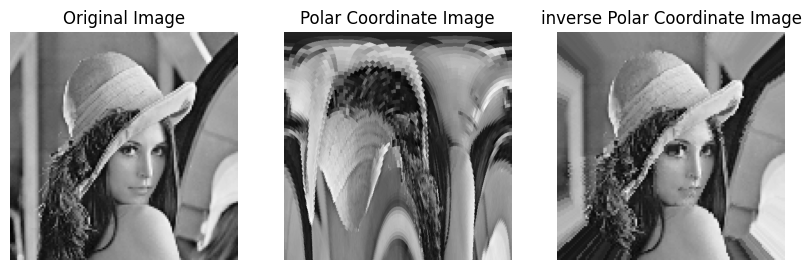

In [6]:
if __name__ == "__main__":
    # Load the image
    # image = cv2.imread("lena/lena.jpg", cv2.IMREAD_GRAYSCALE)
    # #image = cv2.resize(image, (128, 128))
    image = cv2.imread("/content/Lenna_(test_image).png", cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))

    # image = np.array([[1, 2, 3, 4, 4 ,5],
    #        [5, 6, 7, 8,3,3],
    #        [9, 10, 11, 12, 9, 8],
    #        [13, 14, 15, 16, 7, 8],
    #        [3, 4, 15, 6, 7, 8],
    #        [9, 10, 11, 12, 9, 8]],dtype=np.uint8)
    pit = PolarImageTransformation()
    print("Resolution of Original Image")
    print(image.shape)
    polar_image = pit.car_to_pol_chun(image)
    print("Resolution of polar Image")
    print(polar_image.shape)
    car_image = pit.pol_to_car_chun(polar_image)
    print("Resolution of reconstructed Image")
    print(car_image.shape)
    pit.display_image("Image", image, polar_image, car_image)

    # polar_image = pit.car_to_pol_zhang(image,1)
    # polar_image = pit.car_to_pol_chun(image)
    # # Convert to polar coordinates
    # developed algorithm
    # polar_image = pit.cartesian_to_polar_image(image)
    # inverse_polar_image = pit.polar_to_cartesian_image(polar_image)
    # title = "Manual"
    # msre = np.sum(np.square(image - inverse_polar_image)) / np.sum(np.square(image))
    # print("Reconstruction error : ", msre)

    # Based on paper modified
    # polar_image = pit.car_to_pol(image)
    # inverse_polar_image = pit.pol_to_car(polar_image)
    # msre = np.sum(np.square(image - inverse_polar_image)) / np.sum(np.square(image))
    # print("Reconstruction error : ", msre)
    # title = "Manual"

    # Based on scipy package
    # polar_image = pit.topolar(image)
    # inverse_polar_image = pit.tocart(polar_image)
    # title = "Scipy Package"

    # # Based on OpenCv package
    # polar_image = pit.cartesian_to_linear_polar(image)
    # inverse_polar_image = pit.linear_polar_cartesian_image(polar_image)
    # msre = np.sum(np.square(image - inverse_polar_image)) / np.sum(np.square(image))
    # print("Reconstruction error : ", msre)
    # title = "OpenCv Linear"

    # Based on OpenCv package
    # polar_image = pit.cartesian_to_linear_logpolar(image)
    # inverse_polar_image = pit.linear_log_polar_cartesian_image(polar_image)
    # title = "OpenCv log Linear"

    # # inverse_polar_image = pit.pol_to_car_zhang(polar_image,1)
    # # inverse_polar_image = pit.pol_to_car_chun(polar_image)
    # msre = np.sum(np.square(image - inverse_polar_image)) / np.sum(np.square(image))
    # print("Reconstruction error : ", msre)
    # # title = "Chun"



    # pit.display_image(title,image,polar_image, inverse_polar_image)



